In [ ]:
#서울시 부동산 실거래 데이터를 활용해 자치구별/법정동별 거래 금액의 분포를 파악하고, 고가 지역의 특징을 분석
    # 예상: 고가지역은 건물명이 보통 ..., 층수는 보통 ...,신축, ..., 면적이 ...,
# “서울의 부동산 가격은 어디가 높고, 그 이유는 무엇인가?”

In [59]:
import requests  # HTTP 요청을 보내고 응답을 받을 수 있도록 해주는 라이브러리
import xml.etree.ElementTree as ET  # XML 데이터를 파싱(분석)하고 다루기 위한 라이브러리
import pandas as pd  # 데이터프레임을 활용하여 데이터를 효율적으로 처리하기 위한 라이브러리
from datetime import datetime, timedelta  # 날짜 및 시간 계산을 위해 필요한 라이브러리
import numpy as np


In [ ]:
# 서울 열린 데이터 광장 인증키 : '745062564a6d6b6a3931664f55684c'
# 서울시 부동산 실거래가 정보(주소 : https://data.seoul.go.kr/dataList/OA-21275/S/1/datasetView.do)

SyntaxError: invalid syntax (2240149300.py, line 4)

In [60]:
api_key = '745062564a6d6b6a3931664f55684c'
estate_url = 'http://openapi.seoul.go.kr:8088/'


In [61]:
# 데이터 로드
# API URL 구성 (날짜별 버스 데이터 요청)
url = f'http://openapi.seoul.go.kr:8088/{api_key}/xml/tbLnOpendataRtmsV/1/1000/'

# API 요청을 보냄
response = requests.get(url)  # requests 라이브러리를 사용하여 GET 요청 보내기)
print("답: 상태 코드:", response.status_code)

# XML 응답 데이터를 파싱
root = ET.fromstring(response.content)  # API 응답 데이터를 XML 형식으로 변환)

root

답: 상태 코드: 200


<Element 'tbLnOpendataRtmsV' at 0x0000011CA8A1F6F0>

In [47]:
# 데이터를 저장할 리스트 생성
estate_data = []

# 목표 : "물건이 비싼 지역과 원인을 분석"
# THING_AMT	- 물건금액(만원)
# CGG_NM	- 자치구명, STDG_CD   - 법정동명
# BLDG_NM - 건물명, ARCH_AREA - 건물 면적, LAND_AREA - 토지 면적, FLR - 층, ARCH_YR - 건축년도

for row in root.findall('.//row'):
    estate_data.append({
        '자치구명': row.find('CGG_NM').text if row.find('CGG_NM') is not None else np.nan,
        # '법정동명': row.find('STDG_CD').text if row.find('STDG_CD') is not None else np.nan, # -> 동까지 필요 없을듯?
        '건물명': row.find('BLDG_NM').text if row.find('BLDG_NM') is not None else np.nan,
        '건물면적': row.find('ARCH_AREA').text if row.find('ARCH_AREA') is not None else np.nan,
        '토지면적': row.find('LAND_AREA').text if row.find('LAND_AREA') is not None else np.nan,
        '층': row.find('FLR').text if row.find('FLR') is not None else np.nan,
        '건축년도': row.find('ARCH_YR').text if row.find('ARCH_YR') is not None else np.nan,
        '물건금액(만원)': row.find('THING_AMT').text if row.find('THING_AMT') is not None else np.nan
    })

estate_data = pd.DataFrame(estate_data)
estate_data

,자치구명,건물명,건물면적,토지면적,층,건축년도,물건금액(만원)
0,송파구,뮤지컬파크,49.71,26.000000,3,2015,49000
1,영등포구,카사데로사빌,28.95,23.000000,3,2024,59990
2,마포구,LG팰리스빌딩,92.6,116.470000,9,1999,55000
3,금천구,행복이가득한집(861-66),29.95,18.000000,3,2016,24500
4,금천구,리버스타운,54.4,0.000000,5,2016,38000
...,...,...,...,...,...,...,...
995,영등포구,동원에이스뷰3차,29.58,14.000000,4,2020,31500
996,중랑구,풍산그린빌라,51.18,21.000000,1,1995,17000
997,강북구,극동,84.99,0.000000,6,1992,54800
998,서초구,서초더샵포레,114.68,0.000000,8,2014,190000


In [ ]:
estate_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   자치구명      1000 non-null   object
 1   법정동명      1000 non-null   object
 2   건물명       982 non-null    object
 3   건물면적      1000 non-null   object
 4   토지면적      1000 non-null   object
 5   층         982 non-null    object
 6   건축년도      1000 non-null   object
 7   물건금액(만원)  1000 non-null   object
dtypes: object(8)
memory usage: 62.6+ KB


In [62]:
# 수치형인데 범주형 타입으로 되어있는 피처 타입 변환
num_col = ['건물면적', '토지면적', '층', '건축년도', '물건금액(만원)']

for col in num_col:
    estate_data[col] = pd.to_numeric(estate_data[col], errors='coerce') # coerce : 변환할 수 없는 건 NA 처리

print(estate_data.info())
print(estate_data.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   자치구명      1000 non-null   object 
 1   건물명       982 non-null    object 
 2   건물면적      1000 non-null   float64
 3   토지면적      1000 non-null   float64
 4   층         982 non-null    Int64  
 5   건축년도      1000 non-null   Int64  
 6   물건금액(만원)  1000 non-null   Int64  
dtypes: Int64(3), float64(2), object(2)
memory usage: 57.7+ KB
None
자치구명         0
건물명         18
건물면적         0
토지면적         0
층           18
건축년도         0
물건금액(만원)     0
dtype: int64


In [ ]:
# 결측치가 매우 적으므로 과감하게 삭제
estate_data = estate_data.dropna()

<class 'pandas.core.frame.DataFrame'>
Index: 982 entries, 0 to 999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   자치구명      982 non-null    object 
 1   건물명       982 non-null    object 
 2   건물면적      982 non-null    float64
 3   토지면적      982 non-null    float64
 4   층         982 non-null    Int64  
 5   건축년도      982 non-null    Int64  
 6   물건금액(만원)  982 non-null    Int64  
dtypes: Int64(3), float64(2), object(2)
memory usage: 64.3+ KB


In [ ]:
estate_data.describe().T 
# 토지면적이 이상하고, 건축년도도 0으로 이상함 -> 이상치 탐색 필요

,count,mean,std,min,25%,50%,75%,max
건물면적,982.0,59.33592,26.700754,12.96,37.8725,59.43,84.575,202.2
토지면적,982.0,12.668755,18.833804,0.0,0.0,0.0,25.0,137.72
층,982.0,7.496945,5.728792,-1.0,3.0,6.0,10.0,34.0
건축년도,982.0,1968.265784,269.315918,0.0,1997.0,2004.0,2015.0,2025.0
물건금액(만원),982.0,76183.173116,61306.016869,7000.0,29800.0,58000.0,104450.0,413000.0


In [ ]:
print(estate_data['토지면적'].value_counts()) # 토지면적이 0인게 절반 이상 -> 중앙값 대체 or 피처 제거 고려 (우선 제거하겠음)
print(estate_data.drop('토지면적', axis=1, inplace=True))

토지면적
0.00      583
26.00      16
18.00      16
23.00      15
19.00      15
         ... 
73.00       1
181.00      1
34.89       1
63.00       1
44.00       1
Name: count, Length: 165, dtype: int64

In [ ]:
# IQR 기반 이상치 탐색 및 제거
def remove_outliers_iqr(df, cols):
    cleaned_df = df.copy()
    for col in cols:
        Q1 = cleaned_df[col].quantile(0.25)
        Q3 = cleaned_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        before = len(cleaned_df)
        cleaned_df = cleaned_df[(cleaned_df[col] >= lower) & (cleaned_df[col] <= upper)]
        after = len(cleaned_df)

        print(f"[{col}] IQR 범위: {lower:.2f} ~ {upper:.2f}, 제거된 행: {before - after}")

    return cleaned_df

# 적용할 수치형 컬럼
cols_to_check = ['물건금액(만원)', '건물면적', '건축년도']

# 이상치 제거
estate_data_clean = remove_outliers_iqr(estate_data, cols_to_check)

print("\n이상치 제거 후 데이터셋 크기:", estate_data_clean.shape)

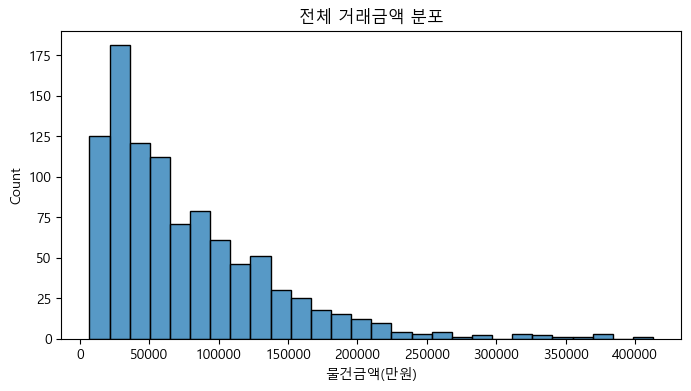

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rc('font', family='Malgun Gothic')  

plt.figure(figsize=(8,4))
sns.histplot(estate_data_clean['물건금액(만원)'])
plt.title('전체 거래금액 분포')
plt.show()

# 긴 꼬리분포

In [ ]:
# 자치구별 거래금액 중앙값 계산
by_gu = estate_data_clean.groupby(['자치구명'])['물건금액(만원)'].median().reset_index().sort_values(by='물건금액(만원)', ascending=False)

C:\Users\SSAFY\AppData\Local\Temp\ipykernel_5200\3838833365.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=by_gu,


<Axes: xlabel='물건금액(만원)', ylabel='자치구명'>

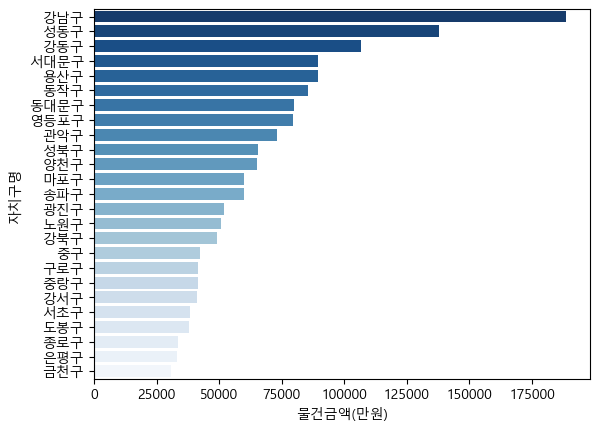

In [ ]:
# 시각화로 거래가격이 가장 비싼 자치구들 판별
sns.barplot(data=by_gu, 
            x='물건금액(만원)', y='자치구명', 
            palette='Blues_r')

# 강남구가 압도적으로 1위
# 이후 성동구, 강동구 약간 차이
# 이후 서대문구, 용산구,... 차이 비슷

In [109]:
estate_data_clean.columns

Index(['자치구명', '건물명', '건물면적', '토지면적', '층', '건축년도', '물건금액(만원)'], dtype='object')

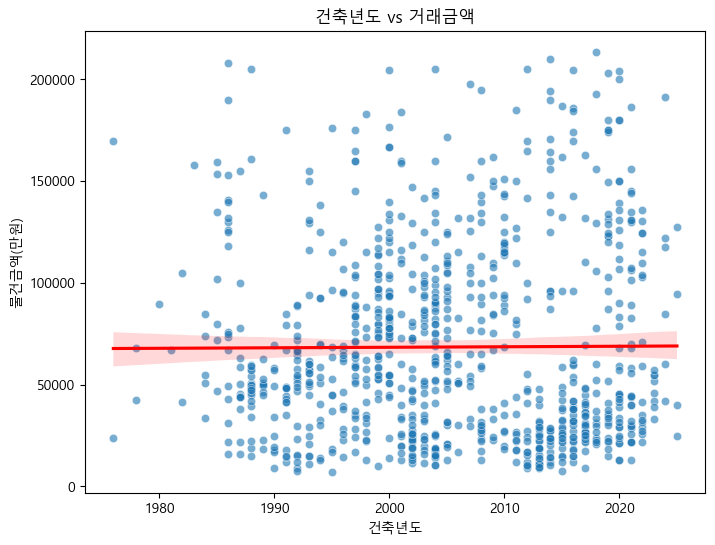

In [ ]:
# 건축년도 vs 거래금액
plt.figure(figsize=(8, 6))
sns.scatterplot(data=estate_data_clean, x='건축년도', y='물건금액(만원)', alpha=0.6)
sns.regplot(data=estate_data_clean, x = '건축년도', y='물건금액(만원)', scatter=False, color='red')
plt.title('건축년도 vs 거래금액')
plt.show()

# 예상 외로, '신축일수록 무조건 비싸다'는 아님(= 건축년도는 가격에 직접적 영향이 크지 않음) -> 건물면적, 건물명, 층의 영향이 더 큰가? 확인 필요
# 거래량은 2000년 이후 건물이 거래의 대부분을 차지

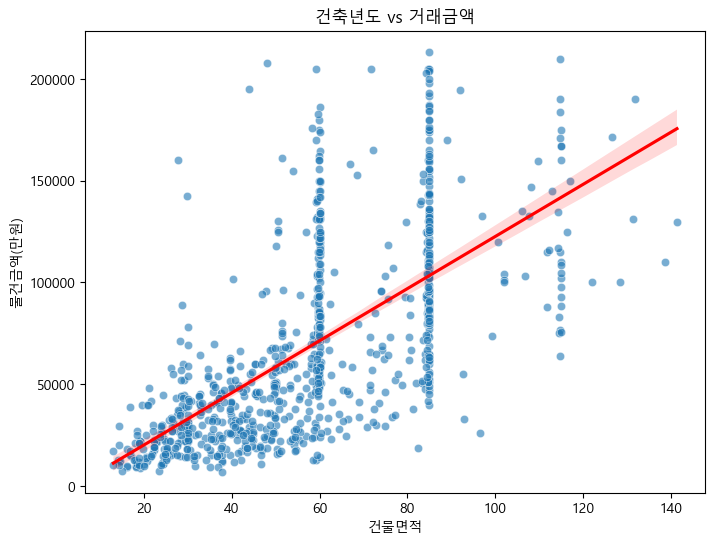

In [ ]:
# 건물면적 vs 거래금액
plt.figure(figsize=(8, 6))
sns.scatterplot(data=estate_data_clean, x='건물면적', y='물건금액(만원)', alpha=0.6)
sns.regplot(data=estate_data_clean, x = '건물면적', y='물건금액(만원)', scatter=False, color='red')
plt.title('건물면적 vs 거래금액')
plt.show()

## 당연하게도, 건물 면적이 넓을 수록 거래 금액은 비싸짐!

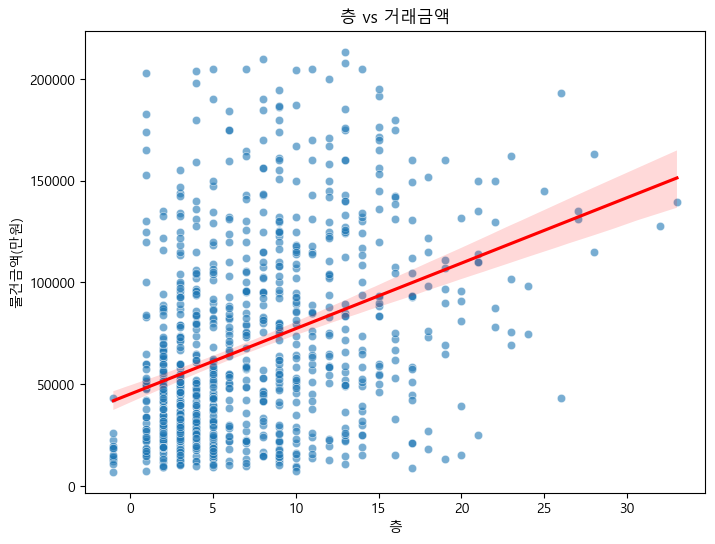

In [ ]:
# 층 vs 거래금액
plt.figure(figsize=(8, 6))
sns.scatterplot(data=estate_data_clean, x='층', y='물건금액(만원)', alpha=0.6)
sns.regplot(data=estate_data_clean, x = '층', y='물건금액(만원)', scatter=False, color='red')
plt.title('층 vs 거래금액')
plt.show()

## 층이 높을 수록 거래 금액은 비싸짐!

In [119]:
# 건물에 따른 가격 차이도 클 것 같은데 확인해보자
by_building = (
    estate_data.groupby('건물명')['물건금액(만원)']
    .median().reset_index()
    .sort_values(by='물건금액(만원)',ascending=False)
)

by_building


,건물명,물건금액(만원)
237,래미안라클래시,393500.0
549,우성아파트,362000.0
79,개포주공5단지,331500.0
232,래미안 리더스원,322000.0
476,신반포12,320000.0
...,...,...
629,진안빌라6동,9200.0
72,강서 동도센트리움,8900.0
505,아르페온1,7470.0
483,신우(A),7400.0


C:\Users\SSAFY\AppData\Local\Temp\ipykernel_5200\552186559.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=by_building,


<Axes: xlabel='물건금액(만원)', ylabel='건물명'>

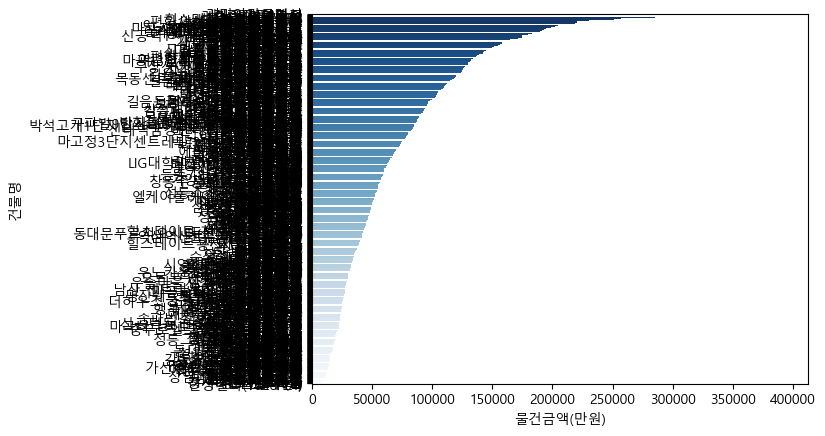

In [ ]:
# 시각화로 거래가격이 가장 비싼 건물명 판별
sns.barplot(data=by_building, 
            x='물건금액(만원)', y='건물명', 
            palette='Blues_r')

## 건물명 nunique가 너무 많음 -> 자치구별로 건물명을 봤을 때 어떤 건물명이 비싼지, 그때 그 건물명은 아파트인지 빌라인지,...

  자치구명          층              건물면적         
             mean median       mean   median
0  강남구  10.227273    9.5  63.209000  60.4450
1  강동구   8.548387    6.5  61.153065  59.9095
2  강북구   8.043478    8.0  61.470739  59.9800
3  강서구   6.985714    6.0  51.926243  43.5700
4  관악구   7.836735    5.0  63.798898  59.7800


C:\Users\SSAFY\AppData\Local\Temp\ipykernel_5200\4090445389.py:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
C:\Users\SSAFY\AppData\Local\Temp\ipykernel_5200\4090445389.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


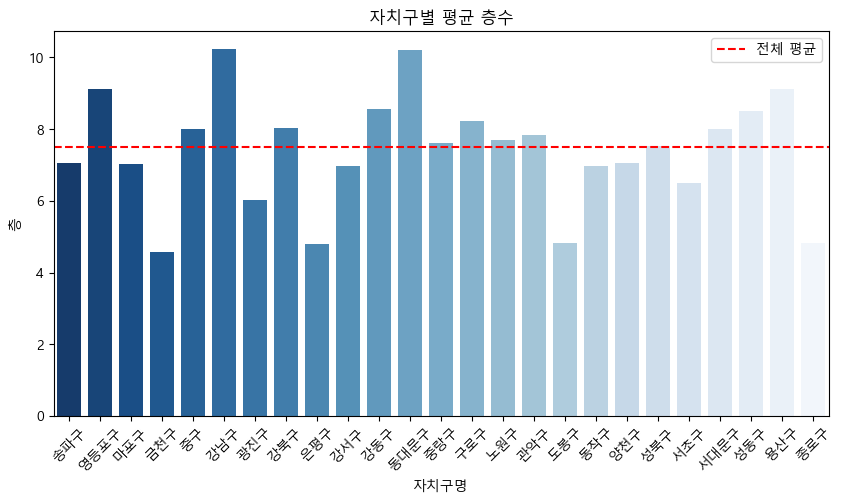

C:\Users\SSAFY\AppData\Local\Temp\ipykernel_5200\4090445389.py:27: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(
C:\Users\SSAFY\AppData\Local\Temp\ipykernel_5200\4090445389.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


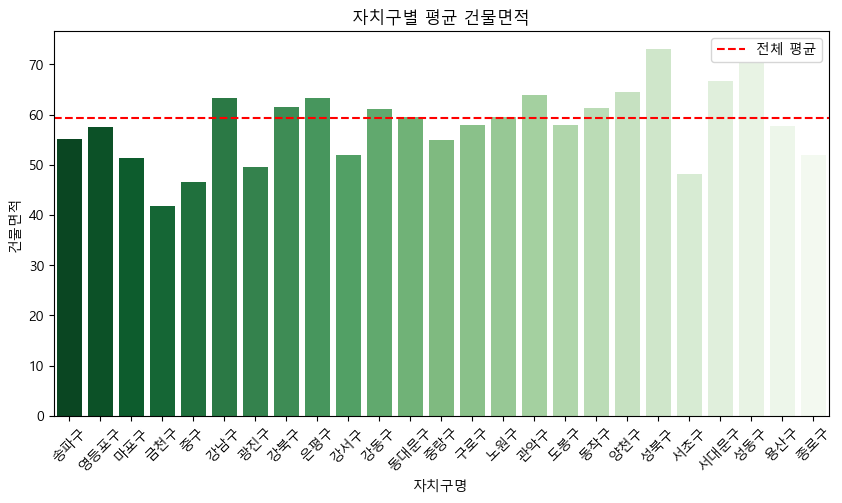

In [121]:
# 자치구별 층수, 건물면적 평균/중앙값
by_gu_features = (
    estate_data.groupby('자치구명')[['층', '건물면적']]
    .agg(['mean', 'median'])
    .reset_index()
)

print(by_gu_features.head())

# 시각화 - 평균 층수
plt.figure(figsize=(10,5))
sns.barplot(
    data=estate_data,
    x='자치구명', y='층',
    estimator='mean',
    ci=None,
    palette='Blues_r'
)
plt.axhline(estate_data['층'].mean(), color='red', linestyle='--', label='전체 평균')
plt.title('자치구별 평균 층수')
plt.xticks(rotation=45)
plt.legend()
plt.show()

# 시각화 - 평균 건물면적
plt.figure(figsize=(10,5))
sns.barplot(
    data=estate_data,
    x='자치구명', y='건물면적',
    estimator='mean',
    ci=None,
    palette='Greens_r'
)
plt.axhline(estate_data['건물면적'].mean(), color='red', linestyle='--', label='전체 평균')
plt.title('자치구별 평균 건물면적')
plt.xticks(rotation=45)
plt.legend()
plt.show()
